# Imports

In [3]:
from braindecode.datasets import MOABBDataset
from braindecode.preprocessing import (
    exponential_moving_standardize, preprocess, Preprocessor)
from braindecode.preprocessing import \
    create_windows_from_events, create_fixed_length_windows

from numpy import multiply

from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

2023-10-06 17:45:26.290107: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-06 17:45:26.290137: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-06 17:45:26.290161: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-06 17:45:26.296323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow not install, you could not use those pipelines


# Loading data

In [4]:
subject_id = 3
dataset = MOABBDataset(dataset_name="BNCI2014_001", subject_ids=[subject_id])

In [5]:
# Dataset raw -- sem corte em freq, sem janelamento
dataset.datasets[0].raw.to_data_frame()

,time,Fz,FC3,FC1,FCz,FC2,FC4,C5,C3,C1,...,CP2,CP4,P1,Pz,P2,POz,EOG1,EOG2,EOG3,stim
0,0.000,6.494141,-0.146484,4.736328,3.857422,2.148437,-2.587891,-1.660156,-1.464844,0.488281,...,-6.884766,-7.910156,-14.062500,-9.423828,-13.525391,-18.066406,-3.417969,8.300781,5.859375,0.0
1,0.004,3.906250,-2.832031,1.269531,0.341797,-1.855469,-6.396484,-5.810547,-5.419922,-1.171875,...,-11.718750,-13.378906,-16.699219,-13.281250,-19.335937,-23.095703,2.441406,10.253906,0.976562,0.0
2,0.008,9.912109,6.738281,7.226562,7.666016,3.955078,2.490234,0.976562,3.515625,5.371094,...,-4.003906,-4.394531,-8.837891,-4.980469,-10.742188,-13.867187,9.277344,13.671875,6.347656,0.0
3,0.012,7.421875,4.003906,4.638672,6.591797,1.025391,3.564453,2.685547,6.005859,4.541016,...,-4.931641,-6.152344,-8.251953,-7.226562,-13.623047,-17.675781,10.742188,13.183594,5.859375,0.0
4,0.016,-5.712891,-4.687500,-5.566406,-4.638672,-9.472656,-8.105469,-5.810547,-2.343750,-3.369141,...,-13.525391,-15.380859,-14.013672,-14.013672,-21.191406,-23.339844,-5.371094,0.000000,-6.347656,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96730,386.920,-18.261719,-8.789062,-11.669922,-13.525391,-17.480469,-20.947266,-7.177734,-6.933594,-9.375000,...,-23.876953,-28.955078,-11.425781,-18.798828,-20.068359,-14.160156,-1.953125,-46.386719,-12.207031,0.0
96731,386.924,-8.056641,4.589844,1.562500,-3.759766,-5.419922,-10.986328,5.126953,4.003906,2.099609,...,-14.501953,-19.970703,-2.880859,-10.009766,-11.083984,-4.882812,0.976562,-45.898438,-12.207031,0.0
96732,386.928,-14.160156,5.419922,-3.173828,-4.394531,-10.156250,-12.353516,-0.292969,3.271484,-3.417969,...,-16.748047,-22.851562,-5.957031,-12.207031,-13.232422,-7.373047,-1.464844,-50.781250,-10.742188,0.0
96733,386.932,-24.707031,-12.402344,-15.869141,-19.970703,-22.265625,-30.810547,-13.037109,-14.355469,-15.673828,...,-27.832031,-33.056641,-16.503906,-23.193359,-23.095703,-15.771484,-10.253906,-56.152344,-20.507812,0.0


# Preprocess

In [4]:
# Parameters for filtering
low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering

# Paramater for resampling
newfreq = 100

# Parameter for scaling
factor = 1e6

preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
    Preprocessor("resample", sfreq=newfreq), # Resampling
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor("set_eeg_reference", ref_channels="average", ch_type="eeg") # Common Average Reference
]

# Transform the data
preprocess(dataset, preprocessors, n_jobs = -1);

/home/barbon/.virtualenvs/ia376/lib/python3.11/site-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')
2023-10-06 11:36:51.847639: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-06 11:36:51.847864: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-06 11:36:51.847911: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-06 11:36:51.858883: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optim

Tensorflow not install, you could not use those pipelines
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Tensorflow not install, you could not use those pipelines
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Tensorflow not install, you could not use those pipelines
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Tensorflow not install, you could not use those pipelines
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Tensorflow not install, you could not use those pipelines
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Tensorflow not install, you could not use those pipelines
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Tensorflow not install, you could not use those pipelines
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Tensorflow not install, you could not use those pipelin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [5]:
dataset.datasets[0].raw

<RawArray | 22 x 38694 (386.9 s), ~6.5 MB, data loaded>

Effective window size : 20.480 (s)


/home/barbon/.virtualenvs/ia376/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


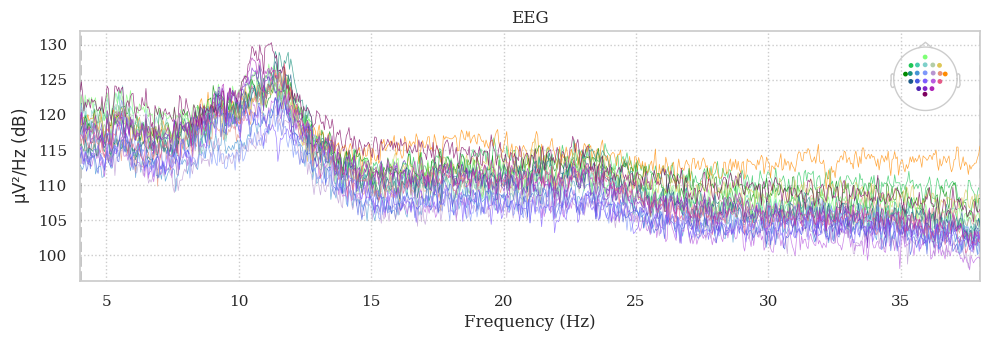

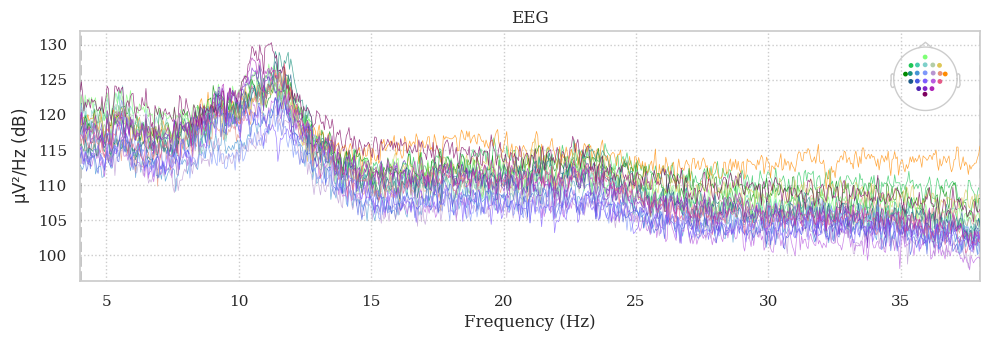

In [6]:
import matplotlib.pyplot as plt
# dataset.datasets[0].raw.compute_psd().plot(picks='eeg')
# plt.show()
dataset.datasets[0].raw.compute_psd(fmin=4, fmax=38).plot(picks='eeg')
# plt.show()
# dataset.datasets[0].raw.compute_psd(fmin=4, fmax=38).plot(picks=['C3','Cz','C4'])
# plt.show()

In [8]:
# sfreq = dataset.datasets[0].raw.info['sfreq']
# # For epochs ranging from -0.5s to 2.5s
# trial_start_offset_seconds = -0.5
# trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)
# trial_stop_offset_seconds = -2
# trial_stop_offset_samples = int(trial_stop_offset_seconds * sfreq)

# windows_dataset = create_windows_from_events(
#     dataset,
#     trial_start_offset_samples=trial_start_offset_samples,
#     trial_stop_offset_samples=trial_stop_offset_samples,
#     preload=True,
#     # mapping = {'left_hand': 0, 'right_hand': 1},
#     # picks = ['C3', 'Cz', 'C4']
# )

In [24]:
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=0,
    trial_stop_offset_samples=100,
    window_size_samples=400,
    window_stride_samples=100,
    preload=True,
    # mapping = {'left_hand': 0, 'right_hand': 1},
    picks = ['C3', 'Cz', 'C4']
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']


## Splitting

We can easily split ds based on a criteria applied to the description
DataFrame:



In [10]:
subsets = dataset.split("session")
print({subset_name: len(subset) for subset_name, subset in subsets.items()})

{'session_E': 232164, 'session_T': 232164}


In [11]:
splitted = windows_dataset.split('session')
full_train_set = splitted['session_T']
evaluation_set = splitted['session_E']

Next, we use a windower to extract events from the dataset based on events:

In [17]:
channels = []


def get_windows_dataset(dataset, channels):

    # Configuration
    trial_start_offset_samples=0
    trial_stop_offset_samples=100
    window_size_samples=400 # Numero de samples em uma janela. Como sfreq=100, definido anteriormente, janela será de 4s
    window_stride_samples=100
    drop_last_window=False
    verbose = None

    if len(channels) != 0:
        windows_dataset = create_windows_from_events(
        concat_ds = dataset, 
        trial_start_offset_samples = trial_start_offset_samples, 
        trial_stop_offset_samples = trial_stop_offset_samples,
        window_size_samples = window_size_samples, # Numero de samples em uma janela. Como sfreq=100, definido anteriormente, janela será de 4s
        window_stride_samples = window_stride_samples,
        drop_last_window=drop_last_window,
        picks = channels,
        verbose = verbose
        )
    else:
        windows_dataset = create_windows_from_events(
        concat_ds = dataset, 
        trial_start_offset_samples = trial_start_offset_samples, 
        trial_stop_offset_samples = trial_stop_offset_samples,
        window_size_samples = window_size_samples, # Numero de samples em uma janela. Como sfreq=100, definido anteriormente, janela será de 4s
        window_stride_samples = window_stride_samples,
        drop_last_window=drop_last_window,
        verbose=verbose
)

    return windows_dataset

windows_dataset = get_windows_dataset(dataset, channels = channels)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
96 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 96 events and 400 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
96 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 96 events and 400 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
96 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 96 events and 400 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
96 matching events 

In [18]:
# windows_dataset = create_windows_from_events(
#     dataset, 
#     trial_start_offset_samples=0, 
#     trial_stop_offset_samples=100,
#     window_size_samples=400, # Numero de samples em uma janela. Como sfreq=100, definido anteriormente, janela será de 4s
#     window_stride_samples=100,
#     drop_last_window=False,
#     picks = channels)

We can iterate through the windows_ds which yields a window x,
a target y, and window_ind (which itself contains ``i_window_in_trial``,
``i_start_in_trial``, and ``i_stop_in_trial``, which are required for
combining window predictions in the scorer).



In [19]:
windows_dataset.datasets[0].windows.to_data_frame()

Using data from preloaded Raw for 96 events and 400 original time points ...


,time,condition,epoch,Fz,FC3,FC1,FCz,FC2,FC4,C5,...,C6,CP3,CP1,CPz,CP2,CP4,P1,Pz,P2,POz
0,0.00,left_hand,0,1.229307e+06,-3.491900e+06,-3.069302e+06,-2.967094e+06,-7.998397e+05,2.591863e+05,-4.948091e+06,...,7.074739e+06,-6.026976e+06,-1.295671e+06,8.837760e+05,2.707584e+06,4.715065e+06,1.338807e+06,4.079750e+06,4.611267e+06,3.444905e+06
1,0.01,left_hand,0,2.828024e+05,-3.988919e+06,-6.018607e+06,-3.467554e+06,-2.611381e+06,1.604757e+06,-3.377780e+06,...,3.658116e+06,-1.510100e+06,-1.315089e+06,2.162299e+06,1.785461e+06,2.688028e+06,4.781947e+06,5.510254e+06,4.569179e+06,7.209644e+06
2,0.02,left_hand,0,-2.365982e+06,-5.888123e+06,-5.867660e+06,-5.181322e+06,-1.772000e+06,-7.017465e+05,-9.407376e+05,...,-8.552802e+05,1.281788e+06,2.350754e+06,2.074757e+06,1.341866e+06,5.559815e+05,6.691468e+06,5.571764e+06,3.385919e+06,8.470275e+06
3,0.03,left_hand,0,-3.795275e+06,-5.946126e+06,-4.458842e+06,-4.895762e+06,-1.726492e+06,-7.585232e+05,-1.600117e+06,...,5.516616e+04,1.512356e+06,2.123931e+06,2.130873e+06,1.804916e+06,1.746024e+06,3.877234e+06,3.007671e+06,1.257915e+06,4.260352e+06
4,0.04,left_hand,0,-3.644715e+06,-1.722668e+06,-1.813822e+06,-4.077498e+06,-2.530494e+06,-1.475035e+05,2.500715e+06,...,3.849012e+06,3.599590e+06,6.578599e+05,-4.621449e+05,-1.057689e+06,6.627117e+04,1.510901e+06,-1.348113e+05,-1.066171e+06,2.895190e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38395,3.95,tongue,95,1.292320e+06,-5.523053e+06,-4.959658e+05,3.611592e+06,4.831945e+06,1.538353e+06,-3.805810e+06,...,3.400501e+06,-2.879573e+06,-7.706685e+05,-1.731977e+06,-1.657015e+06,-1.143150e+06,1.198321e+06,-6.451386e+05,-2.769217e+06,3.503385e+06
38396,3.96,tongue,95,4.400443e+06,3.008260e+06,3.786049e+06,6.408321e+06,4.471645e+06,1.000949e+06,4.227927e+06,...,2.323102e+05,-4.580128e+05,-1.977321e+06,-3.199295e+06,-5.341565e+06,-5.995288e+06,-3.404596e+06,-5.571305e+06,-6.671826e+06,-1.781793e+06
38397,3.97,tongue,95,6.568135e+06,1.224498e+07,6.931977e+06,7.126895e+06,3.784669e+06,4.152202e+06,4.420232e+06,...,-6.238193e+06,1.371187e+06,-3.362442e+06,-5.104162e+06,-7.691129e+06,-9.278655e+06,-3.592685e+06,-5.417101e+06,-6.736356e+06,-1.847193e+06
38398,3.98,tongue,95,7.970670e+06,7.542702e+06,6.145903e+06,4.861309e+06,2.886101e+06,8.541826e+05,4.950066e+06,...,-1.817048e+06,1.752057e+06,-1.188479e+06,-3.158935e+06,-6.092943e+06,-7.501259e+06,-3.131148e+06,-3.972276e+06,-5.381558e+06,-5.844249e+06


We visually inspect the windows:


In [20]:
max_i = 2
fig, ax_arr = plt.subplots(1, max_i + 1, figsize=(3.5 * (max_i + 1), 3.5),
                           sharex=True, sharey=True)
for i, (x, y, window_ind) in enumerate(windows_dataset):
    ax_arr[i].plot(x.T)
    # ax_arr[i].set_ylim(-4e-5, 4e-5)
    ax_arr[i].set_title(f"label={y}")
    if i == max_i:
        break

fig.tight_layout()

Using data from preloaded Raw for 1 events and 400 original time points ...
Using data from preloaded Raw for 1 events and 400 original time points ...
Using data from preloaded Raw for 1 events and 400 original time points ...


Alternatively, we can create evenly spaced ("sliding") windows using a
different windower.



In [21]:
sliding_windows_dataset = create_fixed_length_windows(
    dataset, start_offset_samples=0, stop_offset_samples=0,
    window_size_samples=1200, window_stride_samples=1000,
    drop_last_window=False)

print(len(sliding_windows_dataset))
for x, y, window_ind in sliding_windows_dataset:
    print(x.shape, y, window_ind)
    break

sliding_windows_dataset.description

Using data from preloaded Raw for 39 events and 1200 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 39 events and 1200 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 39 events and 1200 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 39 events and 1200 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 39 events and 1200 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 39 events and 1200 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 39 events and 1200 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 39 events and 1200 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 39 events and 1200 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 39 events and 1200 original time points ...
0 bad epochs dropped
Using data

/home/barbon/.virtualenvs/ia376/lib/python3.11/site-packages/braindecode/preprocessing/windowers.py:602: UserWarning: Meaning of `trial_stop_offset_samples`=0 has changed, use `None` to indicate end of trial/recording. Using `None`.
  warnings.warn(


,subject,session,run
0,3,session_T,run_0
1,3,session_T,run_1
2,3,session_T,run_2
3,3,session_T,run_3
4,3,session_T,run_4
5,3,session_T,run_5
6,3,session_E,run_0
7,3,session_E,run_1
8,3,session_E,run_2
9,3,session_E,run_3


Plotting channels from a single window:

In [22]:
n_channels = 22
fig, ax_arr = plt.subplots(n_channels, 1, figsize=(3.5, n_channels * 3.5),
                           sharex=True, sharey=False)
for i, (x, y, window_ind) in enumerate(windows_dataset):
    for n in range(n_channels):
      ax_arr[n].plot(x[n,:].T)
      # ax_arr[n].set_ylim(-4e-5, 4e-5)
      ax_arr[n].set_title(f"label={y}")
    break

fig.tight_layout()

Using data from preloaded Raw for 1 events and 400 original time points ...


Transforms can also be applied on windows in the same way as shown
above on continuous data:



['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz'] 400
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 96 events and 400 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 96 events and 400 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 96 events and 400 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 96 events and 400 original time points ...
NOTE:

/tmp/ipykernel_72530/3320255694.py:3: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.Epochs'>.tmax (3.99 s)
  windows.crop(tmin=start_offset_samples / fs, tmax=stop_offset_samples / fs,
/tmp/ipykernel_72530/3320255694.py:3: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.Epochs'>.tmax (3.99 s)
  windows.crop(tmin=start_offset_samples / fs, tmax=stop_offset_samples / fs,
/tmp/ipykernel_72530/3320255694.py:3: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.Epochs'>.tmax (3.99 s)
  windows.crop(tmin=start_offset_samples / fs, tmax=stop_offset_samples / fs,
/tmp/ipykernel_72530/3320255694.py:3: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.Epochs'>.tmax (3.99 s)
  windows.crop(tmin=start_offset_samples / fs, tmax=stop_offset_samples / fs,
/tmp/ipykernel_72530/3320255694.py:3: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.Epochs

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 96 events and 400 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz'] 300


/tmp/ipykernel_72530/3320255694.py:3: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.Epochs'>.tmax (3.99 s)
  windows.crop(tmin=start_offset_samples / fs, tmax=stop_offset_samples / fs,
/tmp/ipykernel_72530/3320255694.py:3: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.Epochs'>.tmax (3.99 s)
  windows.crop(tmin=start_offset_samples / fs, tmax=stop_offset_samples / fs,


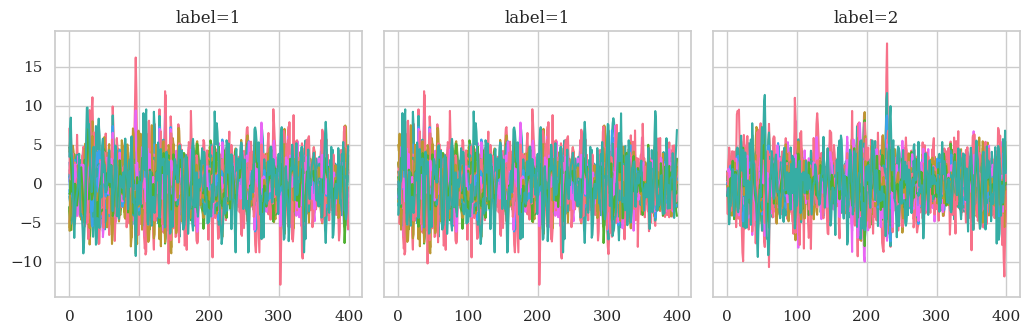

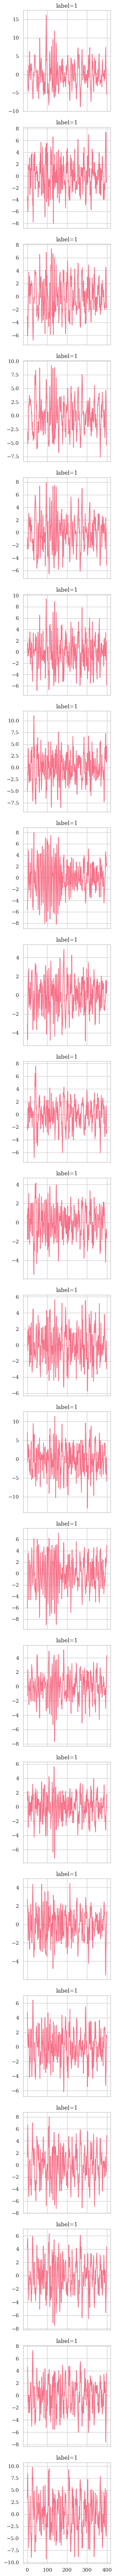

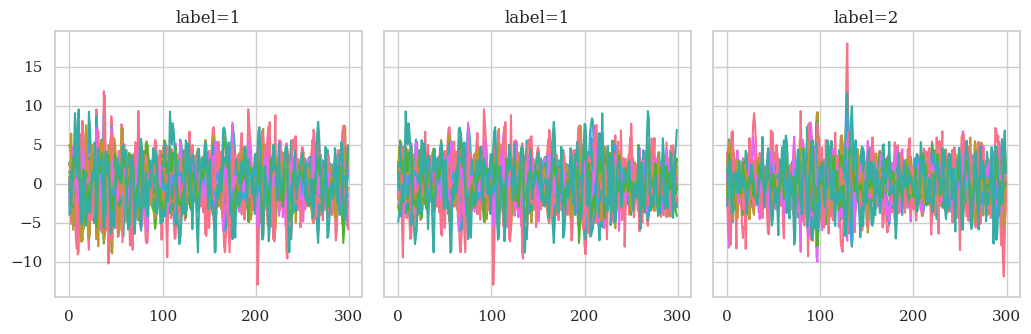

In [23]:
def crop_windows(windows, start_offset_samples, stop_offset_samples):
    fs = windows.info["sfreq"]
    windows.crop(tmin=start_offset_samples / fs, tmax=stop_offset_samples / fs,
                 include_tmax=False)


epochs_preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),
    Preprocessor(crop_windows, apply_on_array=False, start_offset_samples=100,
                 stop_offset_samples=900)
]

print(windows_dataset.datasets[0].windows.info["ch_names"],
      len(windows_dataset.datasets[0].windows.times))
preprocess(windows_dataset, epochs_preprocessors)
print(windows_dataset.datasets[0].windows.info["ch_names"],
      len(windows_dataset.datasets[0].windows.times))


max_i = 2
fig, ax_arr = plt.subplots(1, max_i + 1, figsize=(3.5 * (max_i + 1), 3.5),
                           sharex=True, sharey=True)
for i, (x, y, window_ind) in enumerate(windows_dataset):
    ax_arr[i].plot(x.T)
    # ax_arr[i].set_ylim(-4e-5, 4e-5)
    ax_arr[i].set_title(f"label={y}")
    if i == max_i:
        break

fig.tight_layout()
plt.show()